<a href="https://colab.research.google.com/github/khilo619/Fake-News-Classifier/blob/main/Reddit_FakeNews_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# # IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# # RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [21]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

depi_r_3_competition_1_path = kagglehub.competition_download('depi-r-3-competition-1')

print('Data source import complete.')


Data source import complete.


## Setup, Data Loading

Reading data from: /root/.cache/kagglehub/competitions/depi-r-3-competition-1
Data loaded successfully!

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      48000 non-null  int64 
 1   text    48000 non-null  object
 2   label   48000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB

Label distribution:
label
0    25798
1    22015
2      187
Name: count, dtype: int64


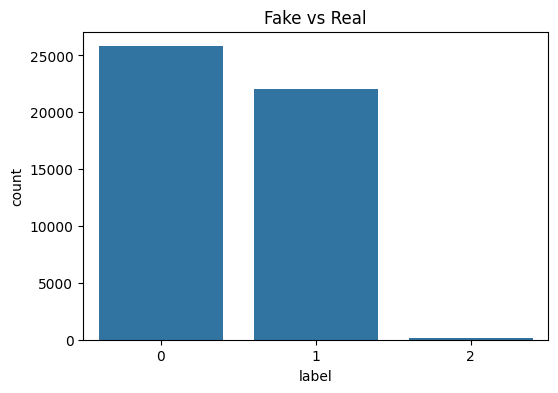

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration
pd.set_option('display.max_columns', 200)

# Load Data directly using the path from kagglehub
# Assumes 'depi_r_3_competition_1_path' variable is already defined from the previous cell
try:
    print(f"Reading data from: {depi_r_3_competition_1_path}")

    # Construct full file paths directly
    train_df = pd.read_csv(f"{depi_r_3_competition_1_path}/xy_train.csv")
    test_df = pd.read_csv(f"{depi_r_3_competition_1_path}/x_test.csv")
    sample_submission_df = pd.read_csv(f"{depi_r_3_competition_1_path}/sample_submission.csv")

    print("Data loaded successfully!")
except FileNotFoundError as e:
    print(f"File issue!! {e}")
    print("\nChecking what files are actually in the directory:")
    # List files to help debug if there's an error
    for file in os.listdir(depi_r_3_competition_1_path):
        print(f"- {file}")

# Continue with your analysis
print("\nDataset information:")
train_df.info()

# Label distribution
print("\nLabel distribution:")
print(train_df['label'].value_counts())

# Let's see the distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train_df)
plt.title("Fake vs Real")
plt.xlabel('label')
plt.ylabel('count')
plt.show()

In [23]:
train_df.head()

,ID,text,label
0,0,Americans Aren't Sure If Flight 370 Vanished T...,1
1,1,Pope Leo X offering indulgences to sinners sho...,0
2,2,News: 5 Uplifting Hypotheticals Of What Could ...,0
3,3,George W. Bush and Jeb Bush at a campaign stop...,0
4,4,The WADA requesting their fair share from Lanc...,0


In [24]:
test_df.head()

,ID,text
0,0,Local soccer club ditch shirt sponsorship deal...
1,1,What is this weird metal thing in the mail fro...
2,2,Donald Trump Jr reportedly told in email of Ru...
3,3,Satanist prayer is held in Alaskan government ...
4,4,There's A Spectacular Error In The Background ...


In [25]:
sample_submission_df.head()

,ID,label
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0


## Data Cleaning

In [26]:
# since we found a label=2 we should remove it
train_df = train_df[train_df['label'] != 2]


In [27]:
print(train_df.info())
print(train_df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 47813 entries, 0 to 47999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      47813 non-null  int64 
 1   text    47813 non-null  object
 2   label   47813 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB
None
label
0    25798
1    22015
Name: count, dtype: int64


## Answering Key Questions

### 1. What is the difference between Character n-gram and Word n-gram? Which one is more affected by the OOV (Out-of-Vocabulary) issue?

* **Word n-grams** are continous segments of words in a given sentence,
let's define define a sentence: khaled love banana.
a words n-gram of n=2 will look like this: [khaled love][love banana]

* **Char n-gram** are continous segments of characters in a given sentence,
let's trace it on "khaled for n=3
it should look like this: [khal][hal][ale][led]

* **Which one is more affected by the OOV???** simply the anwer is the word n-gram, it makes sense as the letter n-gram for example in english is just 26 letters but the words in the dictionary?? i doubt you know them xD

### 2. What is the difference between stop word removal and stemming? Are these techniques language-dependent?

* **Stop words removal** is just the process of removing popular stop words like "a","the",etc..
* **Stemming** is the process of transforming a word to it's root, for example "playing" ==> "play"
* **Lang Dependence?** yes due to the stemming rules and what wrord endings to move and what to keep so lang is imp here

### 3. Is tokenization language-dependent? Why?

* **Yes**, for example the word boundaries in English (whitespaces) need carefull tokenization while in lang like chinese not boundaries at all

### 4. What is the difference between Count Vectorizer and TF-IDF Vectorizer? Is it feasible to use all possible n-grams? How should they be selected?

* **CountVectorizer**: matrix of frequencies, each row for docs and each col for tokens and the cells ==> the count of each token in that doc.

* **TF-IDF Vectorizer**: matrix of frequencies but in aaddition to weighting.
    * TF: same as the CountVectorizer, measure the freq of a word in a doc
    * IDF: How important the term is, low weights for high freq words while high weight for low freq words.
    * TF-IDF: multiplication of TF and IDF.
    * TF-IDF ==> help to identify words that are freq in specific doc but rare across all docs.


* **No it is not Feasible to use all n-grams**, simply for large vocab it will produce very high dimension vector which will make the model very slow

* **How to select N-grams? **
    * **Limit the n**: use uni,bi or try grams, 1 <= n <= 3
    * **Max features**: limit the vocab to be used, use the most frequent ones.
    * ignore terms that have doc freq lower than a min_df or higher than max_df you set


## Modeling

** Model Exploration (Trials)

* Trial 1 | Logistic Regression

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [29]:
X = train_df['text']
y = train_df['label']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Train set size: 38250
Validation set size: 9563


In [30]:
from sklearn.linear_model import LogisticRegression

#create the pipeline for the Tfidf + Logistic Reg
logistic_pipeline = Pipeline(
    [
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('model', LogisticRegression(random_state=42, solver='liblinear'))
    ]
)

print("\nTraining the model....")
logistic_pipeline.fit(X_train, y_train)
print(".....Taining complete.....")

y_pred = logistic_pipeline.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Trial 1 | Logistic Regression | acc = {accuracy:.4f}")


Training the model....
.....Taining complete.....
Trial 1 | Logistic Regression | acc = 0.8079


* Trial 2 | Naive Bayes

In [31]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_pipeline = Pipeline(
    [
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('model', MultinomialNB())
    ]
)

print("\nTraining the model....")
naive_bayes_pipeline.fit(X_train, y_train)
print(".....Taining complete.....")

y_pred = naive_bayes_pipeline.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Trial 2 | Naive Bayes | acc = {accuracy:.4f}")



Training the model....
.....Taining complete.....
Trial 2 | Naive Bayes | acc = 0.7858


* Trial 3 XGboost

In [32]:
import xgboost as xgb

xgb_pipeline = Pipeline(
    [
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
    ]
)

print("\nTraining the model....")
xgb_pipeline.fit(X_train, y_train)
print(".....Taining complete.....")

y_pred = xgb_pipeline.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Trial 3 | XGBoost | acc = {accuracy:.4f}")


Training the model....


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:48:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


.....Taining complete.....
Trial 3 | XGBoost | acc = 0.7435


* Trial 4: LSTM

In [33]:
# # downloading Glove embeddings
# !wget https://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Embedding, GRU, Dense, SpatialDropout1D, Bidirectional, Attention, GlobalAveragePooling1D, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Model


In [35]:
# class SelfAttention(Layer):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)

#     def build(self, input_shape):
#         # Create trainable weights for the attention mechanism
#         self.W = self.add_weight(
#             name='attention_weight',
#             shape=(input_shape[-1], 1),
#             initializer='glorot_uniform',
#             trainable=True
#         )
#         super().build(input_shape)

#     def call(self, inputs):
#         # Compute attention scores
#         # Shape: (batch_size, sequence_length, 1)
#         scores = tf.matmul(inputs, self.W)
#         scores = tf.tanh(scores)

#         # Compute attention weights (softmax over the sequence)
#         # Shape: (batch_size, sequence_length, 1)
#         attention_weights = tf.nn.softmax(scores, axis=1)

#         # Apply weights to the input sequence
#         # Shape: (batch_size, sequence_length, features)
#         context_vector = inputs * attention_weights

#         # Condense the sequence to a single vector
#         # Shape: (batch_size, features)
#         context_vector = tf.reduce_sum(context_vector, axis=1)
#         return context_vector

# # Tokenizer
# vocab_size = 20000
# max_len = 150
# embedding_dim = 100

# tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
# tokenizer.fit_on_texts(X_train)

# X_train_seq = tokenizer.texts_to_sequences(X_train)
# X_val_seq = tokenizer.texts_to_sequences(X_val)

# X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
# X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

# print(f"Padded training data shape: {X_train_padded.shape}")
# print(f"Padded validation data shape: {X_val_padded.shape}")

# embedding_index = {}
# with open('glove.6B.100d.txt', encoding='utf-8') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embedding_index[word] = coefs

# embedding_matrix = np.zeros((vocab_size, embedding_dim))
# for word, i in tokenizer.word_index.items():
#     if i < vocab_size:
#         embedding_vector = embedding_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector

# # Model setup
# GRU = Sequential(
#     [
#         Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False),
#         SpatialDropout1D(0.2),
#         Bidirectional(GRU(128, dropout=0.2, return_sequences=True)),
#         Bidirectional(GRU(64,  dropout=0.2, return_sequences=True)),
#         Dense(64, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ]
# )

# optimizer = Adam(learning_rate=0.001)
# GRU.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# GRU.summary()

# # Training

# best_model_path = 'best_model.keras'
# callbacks = [
#     EarlyStopping(monitor='val_accuracy', patience=3),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
#     ModelCheckpoint(
#         filepath=best_model_path,
#         monitor='val_accuracy',
#         save_best_only=True,
#         verbose=1
#     )
# ]

# print("\nTraining the model....")
# history = lstm.fit(
#     X_train_padded,
#     y_train,
#     epochs=20,
#     batch_size=64,
#     validation_data=(X_val_padded, y_val),
#     callbacks=callbacks,
#     verbose=2
# )

# best_model = load_model(
#     best_model_path,
#     custom_objects={'SelfAttention': SelfAttention}
# )
# # Evaluation

# val_loss, val_accuracy = best_model.evaluate(X_val_padded, y_val)
# print(f"\nImproved Model | val_acc = {val_accuracy:.4f}")

* Let's FineTune a **Robertaaaa**

In [36]:
!pip install -q torch==2.0.1 transformers==4.30.2 scikit-learn==1.3.0 tqdm

import numpy as np
import pandas as pd
import torch
import random
import os
import gc
import time
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# 2. Set random seeds for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

# 3. Check and set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    # Set memory growth
    torch.cuda.empty_cache()

# 4. Set hyperparameters
MODEL_NAME = "roberta-base"
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1

print(f"Fine-tuning {MODEL_NAME} for {EPOCHS} epochs...")

# 5. Prepare datasets
X_train_texts = X_train.tolist() if hasattr(X_train, 'tolist') else list(X_train)
X_val_texts = X_val.tolist() if hasattr(X_val, 'tolist') else list(X_val)

# Handle binary labels (0,1) correctly
y_train_labels = y_train.astype(int).tolist() if hasattr(y_train, 'tolist') else list(map(int, y_train))
y_val_labels = y_val.astype(int).tolist() if hasattr(y_val, 'tolist') else list(map(int, y_val))

print(f"Training samples: {len(X_train_texts)}")
print(f"Validation samples: {len(X_val_texts)}")

# 6. Load and prepare tokenizer
print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 7. Tokenize data
print("Tokenizing training data...")
train_encodings = tokenizer(
    X_train_texts,
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

print("Tokenizing validation data...")
val_encodings = tokenizer(
    X_val_texts,
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

# 8. Create PyTorch datasets
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(y_train_labels)
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    torch.tensor(y_val_labels)
)

# 9. Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# 10. Load model
try:
    print(f"Loading model: {MODEL_NAME}")
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    model.to(device)
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Trying alternative loading approach...")
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2,
                                                             ignore_mismatched_sizes=True)
    model.to(device)

# 11. Set up optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# 12. Training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, epochs, device):
    best_accuracy = 0.0
    best_model_state = None
    training_stats = []

    for epoch in range(epochs):
        print(f"\n{'=' * 30}")
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"{'=' * 30}")

        # Training
        model.train()
        total_train_loss = 0
        start_time = time.time()

        train_bar = tqdm(train_loader, desc="Training")
        for batch in train_bar:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # Reset gradients
            model.zero_grad()

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass
            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update weights
            optimizer.step()
            scheduler.step()

            # Update tracking
            total_train_loss += loss.item()
            train_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)
        training_time = time.time() - start_time

        print(f"Average training loss: {avg_train_loss:.4f}")
        print(f"Training epoch took: {training_time:.2f}s")

        # Evaluation
        model.eval()
        total_eval_loss = 0
        predictions = []
        true_labels = []

        eval_bar = tqdm(val_loader, desc="Evaluating")
        for batch in eval_bar:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

            total_eval_loss += loss.item()

            # Move to CPU and convert to numpy for metric calculation
            logits = logits.detach().cpu().numpy()
            label_ids = labels.detach().cpu().numpy()

            # Store predictions and true labels
            batch_preds = np.argmax(logits, axis=1)
            predictions.extend(batch_preds)
            true_labels.extend(label_ids)

        avg_val_loss = total_eval_loss / len(val_loader)

        # Calculate metrics
        accuracy = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)

        # Save best model
        if accuracy > best_accuracy:
            print(f"New best model! Accuracy improved from {best_accuracy:.4f} to {accuracy:.4f}")
            best_accuracy = accuracy
            best_model_state = model.state_dict().copy()

        # Print metrics
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")

        # Record stats
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'accuracy': accuracy,
            'f1': f1
        })

    return best_model_state, training_stats, best_accuracy

# 13. Run training
print("\nStarting training and evaluation...")
try:
    best_model_state, training_stats, best_accuracy = train_and_evaluate(
        model, train_loader, val_loader, optimizer, scheduler, EPOCHS, device
    )
    print(f"\nTraining complete! Best accuracy: {best_accuracy:.4f}")

    # Save the best model
    torch.save(best_model_state, "best_transformer_model.pt")
    print("Best model saved to 'best_transformer_model.pt'")

except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()

# 14. Final evaluation with best model
print("\nPerforming final evaluation with best model...")
model.load_state_dict(torch.load("best_transformer_model.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final evaluation"):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

# 15. Calculate and display final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
final_f1 = f1_score(all_labels, all_preds)
final_precision = precision_score(all_labels, all_preds)
final_recall = recall_score(all_labels, all_preds)

print("\n" + "=" * 50)
print("FINAL EVALUATION RESULTS")
print("=" * 50)
print(f"Accuracy:  {final_accuracy:.4f}")
print(f"F1 Score:  {final_f1:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall:    {final_recall:.4f}")
print("=" * 50)

# 16. Model information
param_count = sum(p.numel() for p in model.parameters())
print(f"Model: {MODEL_NAME}")
print(f"Parameters: {param_count:,} (~{param_count/1_000_000:.1f}M)")

# 17. Clean up
del model
torch.cuda.empty_cache()
gc.collect()

print("\nAll done!!! transformer has been successfully trained.")

In [41]:
# our submission file!

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Load the saved weights
model.load_state_dict(torch.load("best_transformer_model.pt"))
model.to(device)
model.eval() # Set model to evaluation mode

test_texts = test_df['text'].tolist()
test_ids = test_df['ID'].tolist()

# Tokenize the test data
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2)

# predictions
final_predictions=[]
with torch.no_grad():
  for batch in tqdm(test_loader, desc="Final evaluation"):
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    final_predictions.extend(preds)

submission_df = pd.DataFrame(
    {
        'ID': test_ids,
        'label': final_predictions
    }
)

submission_df.to_csv('khaled_submission.csv', index=False)
submission_df.head()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Final evaluation:   0%|          | 0/374 [00:00<?, ?it/s]

,ID,label
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0


** Remember our poor xgboost? let's optimize it

In [ ]:
# I will try Bayessian Optimization
# !pip install -q hyperopt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# The hyper param search space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),  # Number of trees
    'max_depth': hp.quniform('max_depth', 3, 15, 1),             # Max depth of a tree
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)), # Learning rate
    'subsample': hp.uniform('subsample', 0.7, 1.0),              # Row sampling
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0), # Column sampling
    'gamma': hp.uniform('gamma', 0, 0.5),                        # Minimum loss reduction
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),                  # L1 regularization
    'reg_lambda': hp.uniform('reg_lambda', 1, 2),                # L2 regularization
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'seed': 42
}

# our objective function (what we want to minimize)
def objective(params):
  params['n_estimators'] = int(params['n_estimators'])
  params['max_depth'] = int(params['max_depth'])

  model = xgb.XGBClassifier(**params)

  # train model
  model.fit(
      X_train_tfidf,
      y_train,
  )

  pred = model.predict(X_val_tfidf)
  accuracy = accuracy_score(y_val, pred)

  loss = 1.0 - accuracy # we want to maximize accuracy but hyperopt minimizes a loss function
  return {'loss':loss, 'status':STATUS_OK, 'accuracy': accuracy}


print("\nStarting Bayesian Optimization... This will take a few minutes.")
trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Number of different hyperparameter combinations to try
    trials=trials,
    rstate=np.random.default_rng(42)
)
print("\nOptimization finished!")

print("="*50)
print("BEST HYPERPARAMETERS FOUND:")
print("="*50)
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
print(best_params)


best_accuracy = 1.0 - trials.best_trial['result']['loss']
print(f"\nBest accuracy achieved during optimization: {best_accuracy:.4f}")
print("="*50)


# 8. Train the final, optimized model (optional, but good practice)
print("\nTraining final model with the best parameters...")
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
final_model.fit(X_train_tfidf, y_train)
final_preds = final_model.predict(X_val_tfidf)
final_accuracy = accuracy_score(y_val, final_preds)

print(f"\nFinal Optimized XGBoost Model Accuracy: {final_accuracy:.4f}")